# pre-trained transfer learning + cutmix&mixup 타당성 검증

#### 이전 aug_test에서 cutmix와 mixup적용 모델(finetune) 오히려 성능이 좋지않아 finetune에대한 실험 try!

- EECS에선 ImageNet과 datasets이 similar하고 little data (10s to 100s ?)면 top layer만 fine-tune하고 quite a lot of data (100s to 1000s)면 few layer를 finetune하라고함.
- 이미 큰 dataset(imagenet)이 pre-trained된 model을 가져왔는데 조금더 작은 데이터셋을 fine-tune할때 augmentation할 필요가 있을까??
    - 일단 stanford_dogs dataset자체가 domain spesific하지 않고 Imagenet과 similar하다고 보여지긴함
    - 하지만 aug_test에서 augmentation 적용하지 않은 resnet50 (pre-trained on imagenet)은 오버피팅 났으니 augmentation으로 줄여보자!!!

- using pre-trained resnet-50 with imagenet
    - finetune VS freeze transfer learning  (model.trainable = False) -> BN은 살리고 moving average를 K.update로 적용
- datasets : tensorflow_datasets stanford_dogs
- resize & scaling만 적용

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import pickle

print('z')

z


In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes

In [3]:
def normalize_and_resize_img_origin(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [4]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img_origin,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [5]:
ds_train = apply_normalize_on_dataset(ds_train)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## all finetune model (이전과 같은거)

In [6]:
resnet50_finetune = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

resnet50_finetune.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


In [7]:
EPOCH = 10

tf.random.set_seed(2020)
resnet50_finetune.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

history_resnet50_finetune = resnet50_finetune.fit(
    ds_train, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

resnet50_finetune.save_weights('resnet50_finetune')
with open('./funetune_gist_and_weights/resnet50_finetune_hist', 'wb') as file_pi:
    pickle.dump(history_resnet50_finetune.history, file_pi)

Train for 750 steps, validate for 536 steps
Epoch 1/10
750/750 [==============================] - 144s 192ms/step - loss: 2.2258 - sparse_categorical_accuracy: 0.4442 - val_loss: 3.1504 - val_sparse_categorical_accuracy: 0.2415
Epoch 2/10
750/750 [==============================] - 129s 172ms/step - loss: 0.7936 - sparse_categorical_accuracy: 0.7783 - val_loss: 1.1906 - val_sparse_categorical_accuracy: 0.6556
Epoch 3/10
750/750 [==============================] - 137s 183ms/step - loss: 0.3071 - sparse_categorical_accuracy: 0.9289 - val_loss: 0.9565 - val_sparse_categorical_accuracy: 0.7204
Epoch 4/10
750/750 [==============================] - 137s 183ms/step - loss: 0.1102 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.9741 - val_sparse_categorical_accuracy: 0.7239
Epoch 5/10
750/750 [==============================] - 137s 183ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.9009 - val_sparse_categorical_accuracy: 0.7428
Epoch 6/10
750/750 [================

In [8]:
history_resnet50_finetune = pickle.load(open('./funetune_gist_and_weights/resnet50_finetune_hist', "rb"))

## Freeze & finetune model

In [12]:
import keras.backend as K

base_model = tf.keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        #pooling='avg',
    )

# 오늘의 교훈 api를 신뢰하지 말자

for layer in base_model.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
            layer.trainable = True
            K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
            K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
        else:
            layer.trainable = False


inputs = keras.Input(shape=(224, 224, 3)) 

x = base_model(inputs) 
x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)
resnet50_freeze = keras.Model(inputs, outputs)


resnet50_freeze.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 299,000
Non-trainable params: 23,534,592
_________________________________________________________________


In [14]:
EPOCH = 10

# # cats_and_dogs
# resnet50_freeze.compile(
#     optimizer=keras.optimizers.Adam(),
#     loss=keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=[keras.metrics.BinaryAccuracy()],
# )

tf.random.set_seed(2020)
resnet50_freeze.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

history_resnet50_freeze = resnet50_freeze.fit(
    ds_train, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

resnet50_freeze.save_weights('resnet50_freeze')
with open('./funetune_gist_and_weights/resnet50_freeze_hist', 'wb') as file_pi:
    pickle.dump(history_resnet50_freeze.history, file_pi)

Train for 750 steps, validate for 536 steps
Epoch 1/10
750/750 [==============================] - 94s 125ms/step - loss: 3.4926 - sparse_categorical_accuracy: 0.2267 - val_loss: 4.0269 - val_sparse_categorical_accuracy: 0.1267
Epoch 2/10
750/750 [==============================] - 90s 121ms/step - loss: 1.9448 - sparse_categorical_accuracy: 0.5075 - val_loss: 1.4855 - val_sparse_categorical_accuracy: 0.5941
Epoch 3/10
750/750 [==============================] - 91s 121ms/step - loss: 1.4277 - sparse_categorical_accuracy: 0.6211 - val_loss: 1.2942 - val_sparse_categorical_accuracy: 0.6313
Epoch 4/10
750/750 [==============================] - 91s 121ms/step - loss: 1.2232 - sparse_categorical_accuracy: 0.6647 - val_loss: 1.1779 - val_sparse_categorical_accuracy: 0.6596
Epoch 5/10
750/750 [==============================] - 91s 121ms/step - loss: 1.0513 - sparse_categorical_accuracy: 0.7087 - val_loss: 1.1149 - val_sparse_categorical_accuracy: 0.6719
Epoch 6/10
750/750 [=====================

In [15]:
history_resnet50_freeze = pickle.load(open('./funetune_gist_and_weights/resnet50_freeze_hist', "rb"))

## All finetune

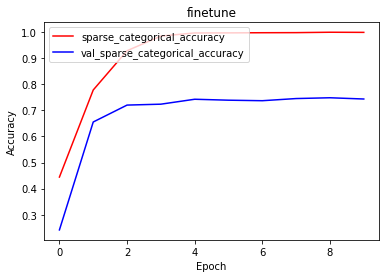

In [16]:
plt.plot(history_resnet50_finetune['sparse_categorical_accuracy'], 'r')
plt.plot(history_resnet50_finetune['val_sparse_categorical_accuracy'], 'b')
plt.title('finetune')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'], loc='upper left')
plt.show()

## freeze and top finetune

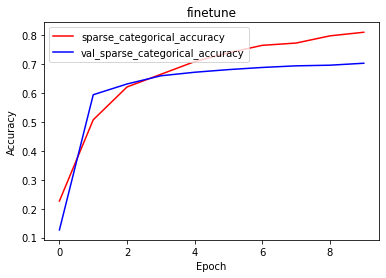

In [17]:
plt.plot(history_resnet50_freeze['sparse_categorical_accuracy'], 'r')
plt.plot(history_resnet50_freeze['val_sparse_categorical_accuracy'], 'b')
plt.title('finetune')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'], loc='upper left')
plt.show()

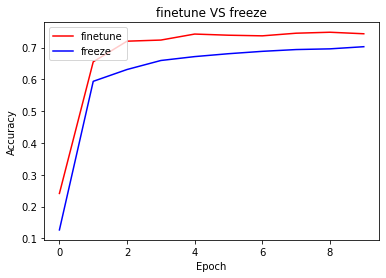

In [18]:
plt.plot(history_resnet50_finetune['val_sparse_categorical_accuracy'], 'r')
plt.plot(history_resnet50_freeze['val_sparse_categorical_accuracy'], 'b')
plt.title('finetune VS freeze')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['finetune', 'freeze'], loc='upper left')
plt.show()

- 일단 resnet50 기본모델에 대해선 all-finetune과 top-finetune 내가 원하는 유의미한 차이 없음 

- aug_test_freeze_v2에서 계속~